# Задание 2.

## 2.1 
Реализовать метод решения СЛАУ, на выбор: LU-разложение или метод квадратного корня. Для матриц A, L, U вычислить числа обусловленности.
Протестировать на разных матрицах: хорошо обусловленных, [очень] плохо обусловленных.

## 2.2 
Для нескольких плохо обусловленных матриц (например, для матриц Гильберта разного, больше 15, порядка) реализовать метод регуляризации: 
* параметр α варьировать в пределах от 10e−12 до 10e−1;
* для каждого конкретного значения α найти числа обусловленности (матриц A + αE) и норму погрешности получившегося решения;
* понять, какое значение α = α в каждом конкретном случае (= для каждой конкретной матрицы) кажется наилучшим.
* Наилучшее α можно
  * находить из предположений, что точным решением является вектор x0 = (1, 1, . . . , 1).T;
  * находить из предположений, что точным решением является случайный вектор x0.

Проверить результат на [другом] случайном векторе x0.

# Imports

In [2]:
from collections import namedtuple
from typing import Tuple, NamedTuple, Iterable, Callable, List, Dict
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

from t01_condition_numbers import ConditionNumbers, calculate_condition_numbers
from common import generate_hilberts_matrix_element, generate_tridiagonal_matrix_element

# I. Solution (LU-decomposition)

In [3]:
def LU_decomposition(A: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    n = A.shape[0]
    L, U = np.zeros((n, n)), np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            sum1 = sum(L[j, k] * U[k, i] for k in range(i))
            sum2 = sum(L[i, k] * U[k, j] for k in range(i))
            U[i, j] = A[i, j] - sum2
            L[j, i] = (A[j, i] - sum1) / U[i, i] if U[i, i] != 0 else float('inf')

    return L, U
    

def solve_using_LU_decomposition(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    def solve_Ly_b(L: np.ndarray, b: np.ndarray) -> np.ndarray:
        y = np.zeros_like(b)
        for i in range(len(b)):
            y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]
            
        return y

    def solve_Ux_y(U: np.ndarray, y: np.ndarray) -> np.ndarray:
        x = np.zeros_like(y)
        for i in range(len(y) - 1, -1, -1):
            x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
            
        return x

    if not np.linalg.det(A):
        raise np.linalg.LinAlgError('Coefficient matrix is singular')

    L, U = LU_decomposition(A)

    y = solve_Ly_b(L, b)
    x = solve_Ux_y(U, y)
    
    return x

# II. Tests (LU-decomposition)

In [4]:
def test_lu_decomposition_matrices_triangularity():
    num_matrices = 10
    matrix_size = 100

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        L, U = LU_decomposition(A)

        for row in range(matrix_size):
            for column in range(matrix_size):
                if row < column:
                    assert L[row, column] == 0, "L matrix should have zeros above diagonal"
                elif row == column:
                    assert L[row, column] == 1, "Diagonal of L matrix should be ones"
                else:  # row > column
                    assert U[row, column] == 0, "U matrix should have zeros below diagonal"

test_lu_decomposition_matrices_triangularity()

In [5]:
def test_lu_decomposition_with_diagonal_input():
    num_tests = 10
    matrix_size = 100
    
    for _ in range(num_tests):
        A = np.diag(np.random.rand(matrix_size))
        L, U = LU_decomposition(A)

        assert np.array_equal(A, np.dot(L, U)), "A should be equal to the dot product of L and U"

test_lu_decomposition_with_diagonal_input()

In [6]:
def test_LU_decomposition_with_various_matrices(matrix_sizes, element_generator):
    for size in matrix_sizes:
        A = np.array([[element_generator(row, column) for column in range(size)] for row in range(size)])
        L, U = LU_decomposition(A)

        assert np.allclose(A, np.dot(L, U)), f"LU decomposition failed for matrix size {size}."

In [7]:
# Test with Hilbert matrices
test_LU_decomposition_with_various_matrices(matrix_sizes=[3, 4, 7, 15, 38, 90], element_generator=generate_hilberts_matrix_element)

In [8]:
# Test with tridiagonal matrices
test_LU_decomposition_with_various_matrices(matrix_sizes=[2, 3, 10, 20, 50, 100], element_generator=generate_tridiagonal_matrix_element)

In [9]:
def test_solve_using_LU_decomposition_with_various_matrices(matrix_sizes, element_generator):
    for size in matrix_sizes:
        A = np.array([[element_generator(row, column) for column in range(size)] for row in range(size)])
        x_true = np.ones(size)
        b = A @ x_true
        
        x_computed = solve_using_LU_decomposition(A, b)
        assert np.allclose(x_true, x_computed), f"Solution mismatch for matrix size {size}. Norm of difference: {np.linalg.norm(x_true - x_computed)}"

In [10]:
# Test with tridiagonal matrices
test_solve_using_LU_decomposition_with_various_matrices(matrix_sizes=[2, 3, 10, 20, 50, 100], element_generator=generate_tridiagonal_matrix_element)

# III. Solution (regularization)

In [11]:
class SolutionUsingRegularization(NamedTuple):
    solution_vector: np.ndarray
    condition_numbers: ConditionNumbers


def solve_using_regularization(A: np.ndarray, b: np.ndarray, alpha: float) -> SolutionUsingRegularization:
    if not np.linalg.det(A):
        raise np.linalg.LinAlgError('Coefficient matrix is singular')

    regularized_matrix = A + alpha * np.identity(A.shape[0])
    
    solution_vector = solve_using_LU_decomposition(regularized_matrix, b)
    condition_numbers = calculate_condition_numbers(regularized_matrix)

    return SolutionUsingRegularization(solution_vector, condition_numbers)

# IV. Tests (regularization)

In [12]:
def test_solve_using_regularization(matrix_sizes, element_generator):
    regularization_parameters = [10 ** (-i) for i in range(5, 12)]

    for size in matrix_sizes:
        A = np.array([[element_generator(row, column) for column in range(size)] for row in range(size)])
        x = np.ones(size)
        b = A.dot(x)

        for alpha in regularization_parameters:
            sol = solve_using_regularization(A, b, alpha).solution_vector
            assert np.allclose(x, sol), f"Regularization failed for matrix size {size} and alpha {alpha}. Error: {np.linalg.norm(x - sol)}"



In [13]:
# Test with tridiagonal matrices
test_solve_using_regularization(matrix_sizes=[2, 5, 8, 10, 20, 45, 78], element_generator=generate_tridiagonal_matrix_element)

# V. Experiments (LU-decomposition)

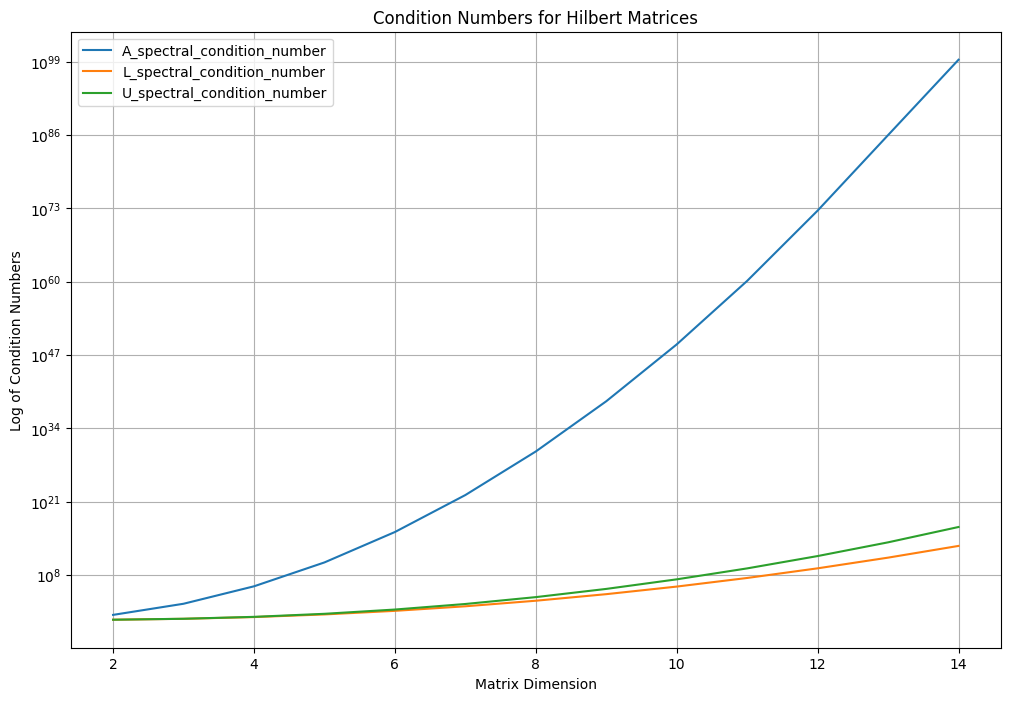

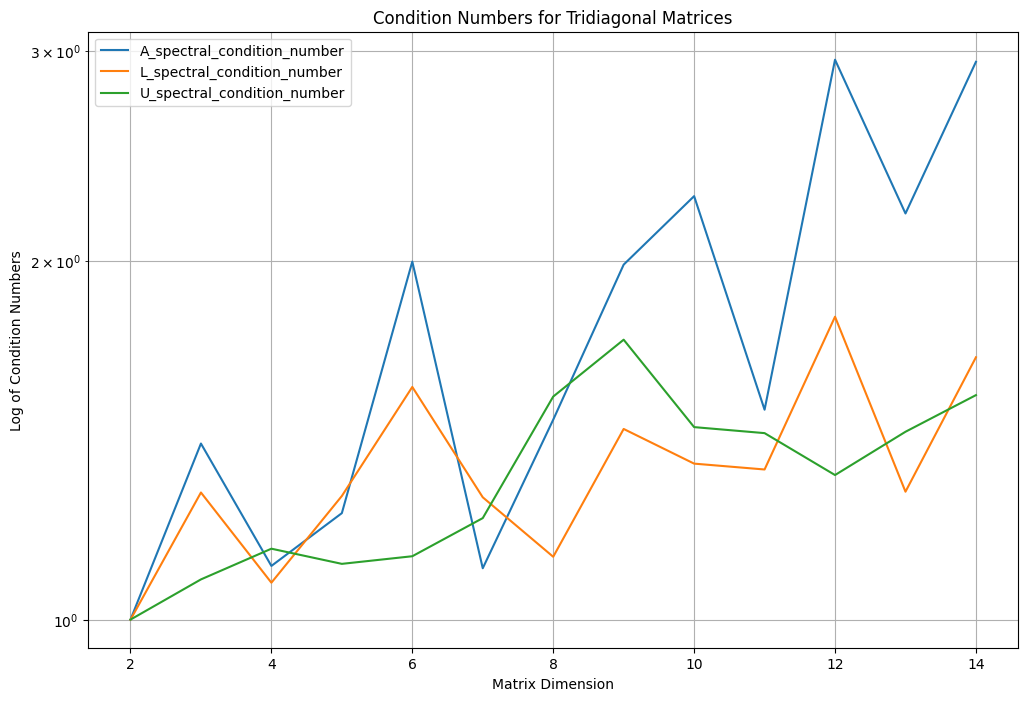

In [14]:
def experiment(dimension_range: Iterable, generate: Callable) -> pd.DataFrame:
    results = []

    for dimension in dimension_range:
        A = np.array([[generate(row, column) for column in range(dimension)] for row in range(dimension)])
        L, U = LU_decomposition(A)
        condition_numbers_A = calculate_condition_numbers(A)
        condition_numbers_L = calculate_condition_numbers(L)
        condition_numbers_U = calculate_condition_numbers(U)
        
        results.append({
            'matrix_dimension': dimension,
            'A_spectral_condition_number': condition_numbers_A.volume,
            'L_spectral_condition_number': condition_numbers_L.volume,
            'U_spectral_condition_number': condition_numbers_U.volume,
        })

    return pd.DataFrame(results)

def plot_results(results: pd.DataFrame, title: str):
    plt.figure(figsize=(12, 8))
    for column in results.columns[1:]:
        plt.semilogy(results['matrix_dimension'], results[column], label=column)
    plt.xlabel('Matrix Dimension')
    plt.ylabel('Log of Condition Numbers')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()

def run_experiments_and_plot():
    dimension_range = range(2, 15)
    
    # Hilbert's Matrix Experiment
    hilbert_results = experiment(dimension_range, generate_hilberts_matrix_element)
    plot_results(hilbert_results, 'Condition Numbers for Hilbert Matrices')
    
    # Tridiagonal Matrix Experiment
    tridiagonal_results = experiment(dimension_range, generate_tridiagonal_matrix_element)
    plot_results(tridiagonal_results, 'Condition Numbers for Tridiagonal Matrices')

run_experiments_and_plot()

# VI. Experiments (regularization)

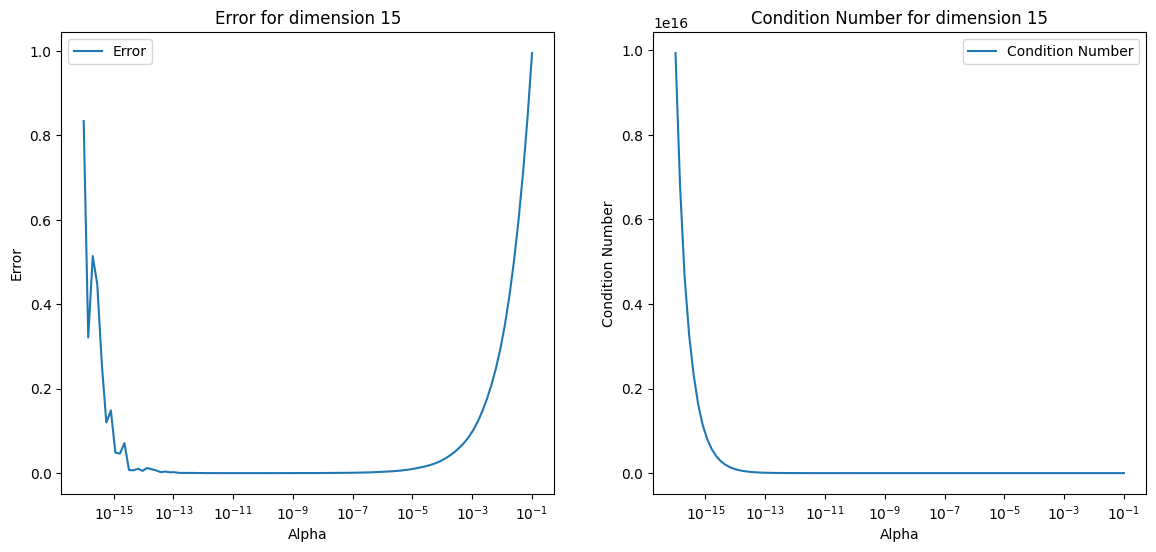

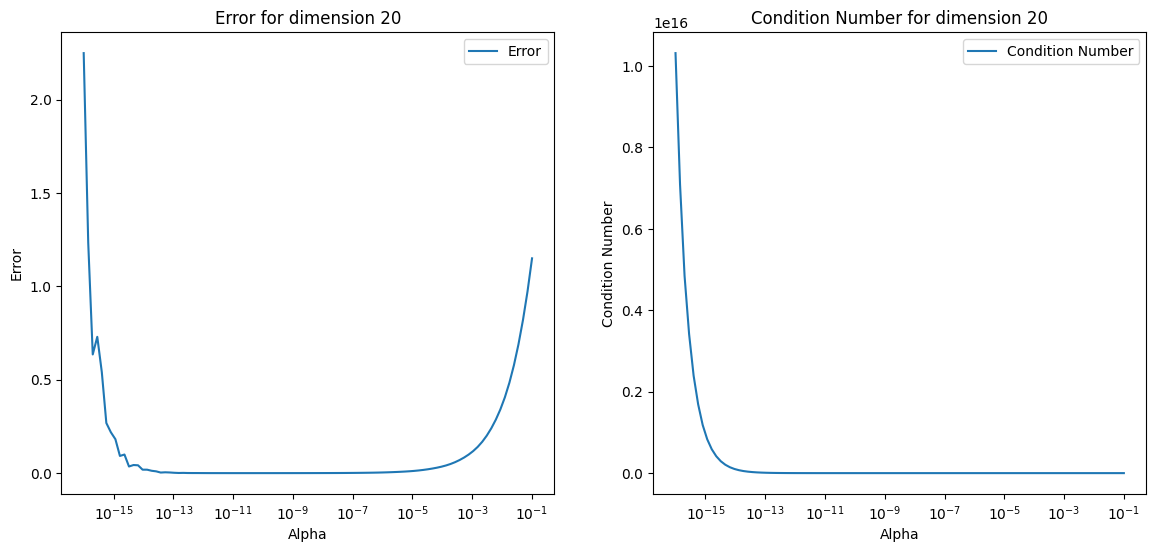

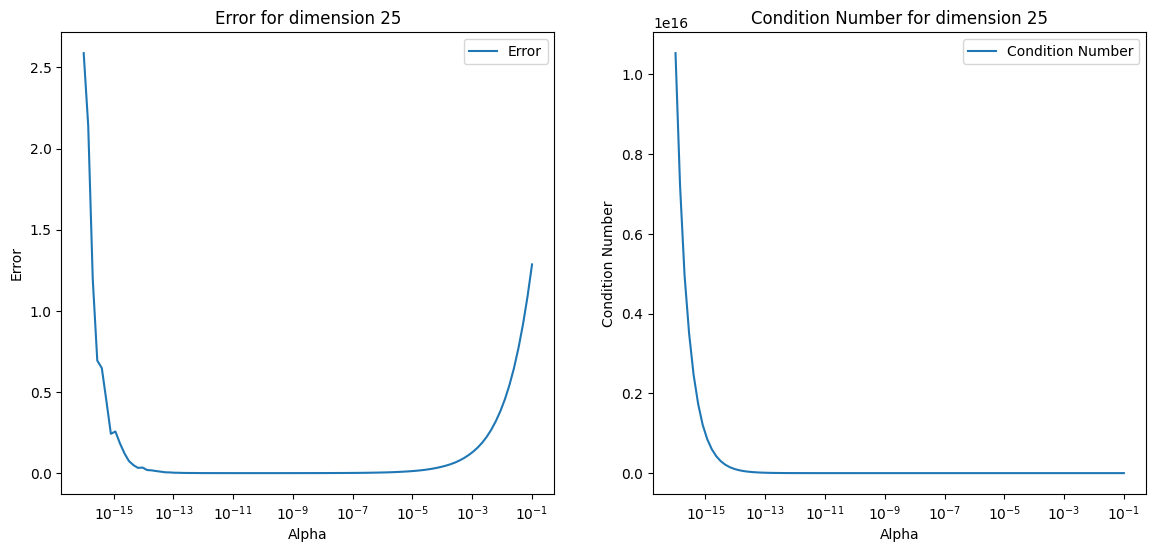

Best alpha for dimension 15: 1e-11
Best alpha for dimension 20: 2.009233002565046e-11
Best alpha for dimension 25: 2.848035868435805e-11


In [15]:
def experiment(generate: Callable, dimensions: List[int], alphas: List[float]) -> Dict[int, Dict[str, List[float]]]:
    results = {}
    
    for dim in dimensions:
        A = np.array([[generate(row, column) for column in range(dim)] for row in range(dim)])
        x_true = np.ones(dim)
        b = A @ x_true
        best_alpha = None
        min_error = float('inf')
        condition_numbers = []
        errors = []
        
        for alpha in alphas:
            regularized_A = A + alpha * np.eye(dim)
            solution = solve_using_regularization(regularized_A, b, alpha)
            x_computed = solution.solution_vector
            error = np.linalg.norm(x_computed - x_true)
            errors.append(error)
            condition_numbers.append(solution.condition_numbers.spectral)
            
            if error < min_error:
                min_error = error
                best_alpha = alpha
        
        results[dim] = {
            'best_alpha': best_alpha,
            'errors': errors,
            'condition_numbers': condition_numbers
        }
        
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.semilogx(alphas, errors, label='Error')
        plt.xlabel('Alpha')
        plt.ylabel('Error')
        plt.title(f'Error for dimension {dim}')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.semilogx(alphas, condition_numbers, label='Condition Number')
        plt.xlabel('Alpha')
        plt.ylabel('Condition Number')
        plt.title(f'Condition Number for dimension {dim}')
        plt.legend()
        
        plt.show()
    
    return results

dimensions = [15, 20, 25]
alphas = np.logspace(-1, -16, 100)  # 100 values from 1e-1 to 1e-12

results = experiment(generate_hilberts_matrix_element, dimensions, alphas)

for dim, res in results.items():
    print(f'Best alpha for dimension {dim}: {res["best_alpha"]}')

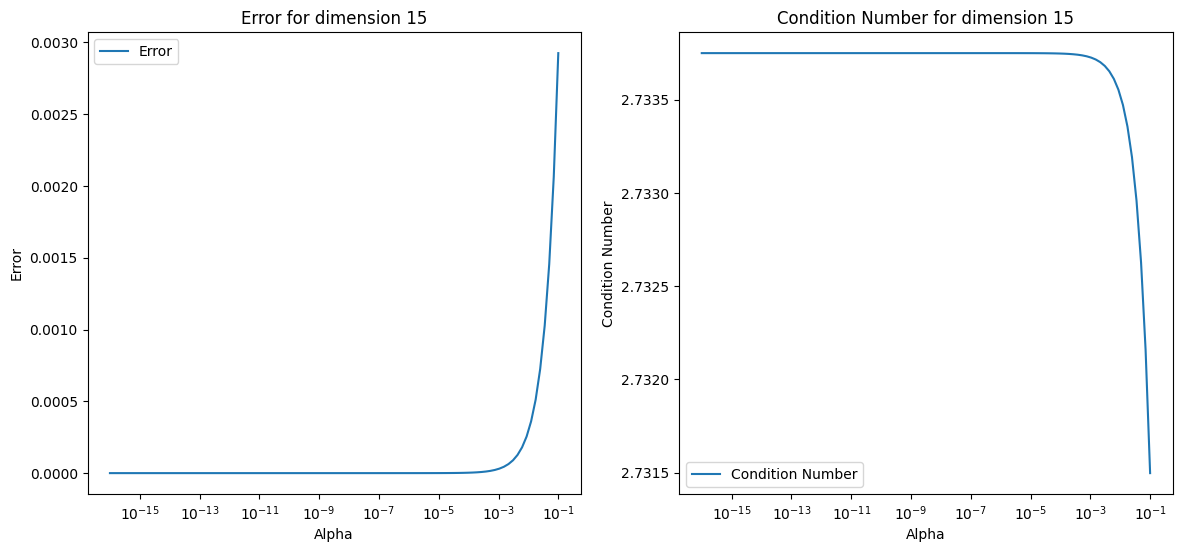

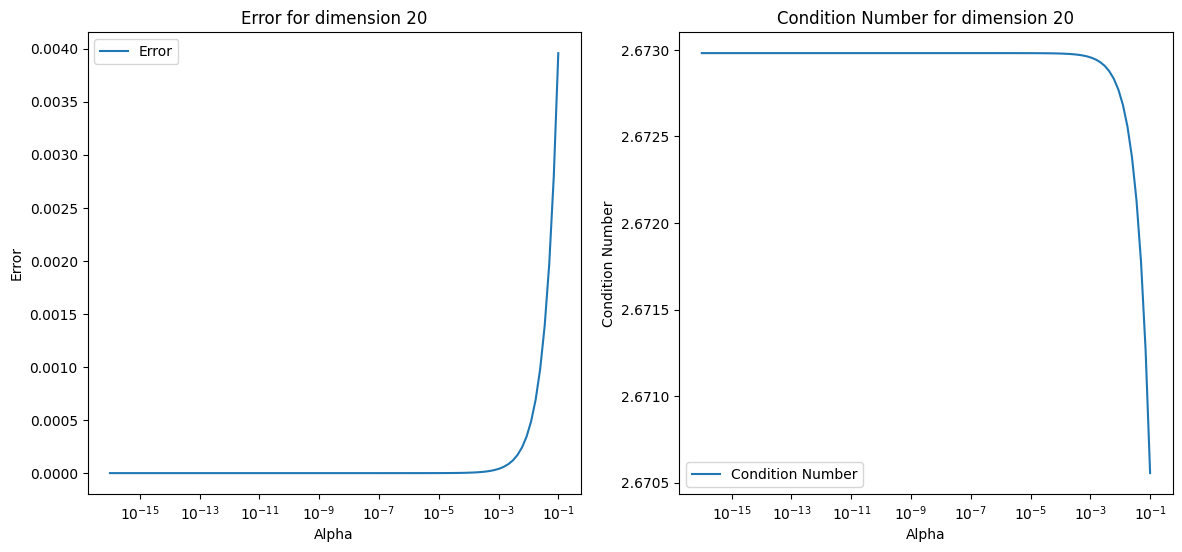

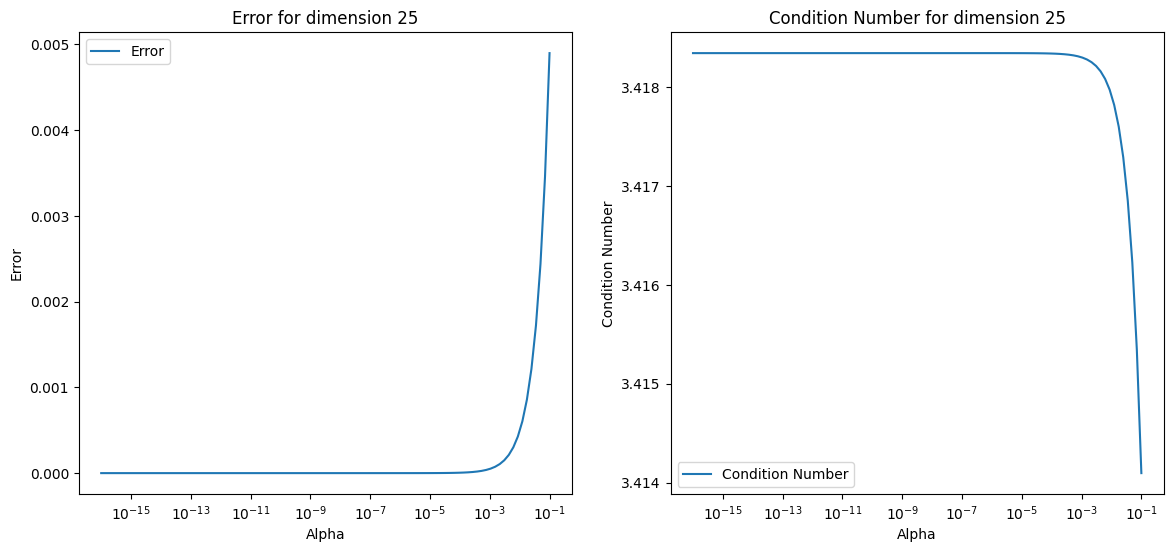

Best alpha for dimension 15: 1.3219411484660287e-14
Best alpha for dimension 20: 1.3219411484660287e-14
Best alpha for dimension 25: 6.5793322465756826e-15


In [16]:
results = experiment(generate_tridiagonal_matrix_element, dimensions, alphas)

for dim, res in results.items():
    print(f'Best alpha for dimension {dim}: {res["best_alpha"]}')